## Access Diver Photoquadrat Score QC (Parquet)
This Jupyter notebook demonstrates how to access and plot diver_photoquadrat_score_qc data, available as a [Parquet](https://parquet.apache.org) dataset stored on S3.

🔗 More information about the dataset is available [in the AODN metadata catalogue](https://catalogue-imos.aodn.org.au/geonetwork/srv/eng/catalog.search#/metadata/None).

📌 The source of truth for this notebook is maintained on [GitHub](https://github.com/aodn/aodn_cloud_optimised/tree/main/notebooks/diver_photoquadrat_score_qc.ipynb).


In [1]:
dataset_name = "diver_photoquadrat_score_qc"

## Install/Update packages and Load common functions

In [2]:
from DataQuery import GetAodn

/Users/thommodin/dev/aodn_cloud_optimised/notebooks/DataQuery.py:3235: UserWarning: registration of accessor <class 'DataQuery.AODNAccessor'> under name 'aodn' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("aodn")


# Understanding the Dataset

## Understanding Parquet Partitioning

Parquet files can be **partitioned** by one or more columns, which means the data is physically organised into folders based on the values in those columns. This is similar to how databases use indexes to optimise query performance.

Partitioning enables **faster filtering**: when you query data using a partitioned column, only the relevant subset of files needs to be read—improving performance significantly.

For example, if a dataset is partitioned by `"site_code"`, `"timestamp"`, and `"polygon"`, filtering on `"site_code"` allows the system to skip unrelated files entirely.

In this notebook, the `GetAodn` class includes built-in methods to efficiently filter data by **time** and **latitude/longitude** using the **timestamp** and **polygon** partitions. Other partitions can be used for filtering via the `scalar_filter`.

Any filtering on columns that are **not** partitioned can be significantly slower, as all files may need to be scanned. However, the `GetAodn` class provides a `scalar_filter` method that lets you apply these filters at load time—before the data is fully read—helping reduce the size of the resulting DataFrame.

Once the dataset is loaded, further filtering using Pandas is efficient and flexible.

See further below in the notebook for examples of how to filter the data effectively.

To view the actual partition columns for this dataset, run:


In [3]:
aodn = GetAodn()
dname = f'{dataset_name}.parquet'
%time aodn_dataset = aodn.get_dataset(dname)

CPU times: user 74.9 ms, sys: 16.8 ms, total: 91.6 ms
Wall time: 829 ms


In [4]:
aodn_dataset.dataset.partitioning.schema

timestamp: int32
polygon: string

## List unique partition values

In [5]:
%%time
unique_partition_value = aodn_dataset.get_unique_partition_values('timestamp')
print(list(unique_partition_value)[0:2])  # showing a subset only

['1241136000', '1396310400']
CPU times: user 4.58 ms, sys: 4.85 ms, total: 9.42 ms
Wall time: 5.97 ms


## Visualise Spatial Extent of the dataset
This section plots the polygons representing the areas where data is available. It helps to identify and create a bounding box around the regions containing data.

/opt/homebrew/Cellar/micromamba/2.3.3/envs/AodnCloudOptimised/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:143: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


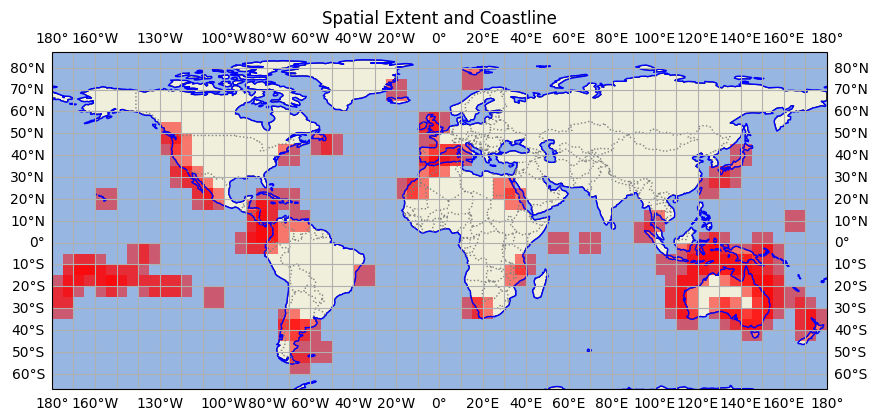

In [6]:
aodn_dataset.plot_spatial_extent()

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [7]:
%%time
aodn_dataset.get_temporal_extent(time_varname="date")

CPU times: user 433 ms, sys: 7.85 ms, total: 441 ms
Wall time: 328 ms


(datetime.date(2006, 9, 2), datetime.date(2024, 12, 17))

## Read Metadata

For all Parquet datasets, we create a sidecar file named **_common_metadata** in the root of the dataset. This file contains both the dataset-level and variable-level attributes.  
The metadata can be retrieved below as a dictionary, and it will also be included in the pandas DataFrame when using the `get_data` method from the `GetAodn` class.

In [8]:
metadata = aodn_dataset.get_metadata()
metadata

2025-11-12 12:35:06,476 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/diver_photoquadrat_score_qc.parquet


{'dataset_id': {'type': 'string'},
 'database': {'type': 'string'},
 'program': {'type': 'string'},
 'country': {'type': 'string'},
 'area': {'type': 'string'},
 'location': {'type': 'string'},
 'site_code': {'type': 'string'},
 'site_name': {'type': 'string'},
 'latitude': {'type': 'double'},
 'longitude': {'type': 'double'},
 'date': {'type': 'date32[day]'},
 'hour': {'type': 'string'},
 'depth': {'type': 'double'},
 'visibility': {'type': 'double'},
 'label_scheme': {'type': 'string'},
 'rls_label': {'type': 'string'},
 'rls_lineage': {'type': 'string'},
 'catami_label': {'type': 'string'},
 'catami_lineage': {'type': 'string'},
 'tags': {'type': 'list<element: string>'},
 'label_count': {'type': 'double'},
 'dataset_total_label_count': {'type': 'double'},
 'percent_cover': {'type': 'double'},
 'sq_annotation_set_id': {'type': 'double'},
 'method': {'type': 'string'},
 'filename': {'type': 'string',
  'units': '1',
  'long_name': 'Filename of the source file'},
 'timestamp': {'type'

# Data Query and Plot

## Create a TIME and BoundingBox filter

This cell loads a subset of the dataset based on a time range and a spatial bounding box. The result is returned as a pandas DataFrame, and basic information about its structure is displayed.

In [9]:
%%time
df = aodn_dataset.get_data(
    date_start='2000-01-01', 
    date_end='2025-12-12',
    lat_min=-45.39845,
    lat_max=-37.822802,
    lon_min=140.493164,
    lon_max=151.87,
    lat_varname="latitude",
    lon_varname="longitude",
    time_varname="date",
)
df.info()

None
(((((((((polygon == "010300000001000000050000000000000000E0604000000000000044C0000000000020624000000000000044C000000000002062400000000000003EC00000000000E060400000000000003EC00000000000E0604000000000000044C0") or (polygon == "01030000000100000005000000000000000080614000000000008046C00000000000C0624000000000008046C00000000000C0624000000000008041C0000000000080614000000000008041C0000000000080614000000000008046C0")) or (polygon == "01030000000100000005000000000000000080614000000000000044C00000000000C0624000000000000044C00000000000C062400000000000003EC000000000008061400000000000003EC0000000000080614000000000000044C0")) or (polygon == "01030000000100000005000000000000000020624000000000000044C0000000000060634000000000000044C000000000006063400000000000003EC000000000002062400000000000003EC0000000000020624000000000000044C0")) and (latitude >= -45.39845)) and (latitude <= -37.822802)) and (longitude >= 140.493164)) and (longitude <= 151.87)) and ((((timestamp >= 1157068800) and (timestamp <=

2025-11-12 12:35:10,517 - aodn.GetAodn - INFO - Retrieving metadata for imos-data-lab-optimised/diver_photoquadrat_score_qc.parquet


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9162 entries, 0 to 9161
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   dataset_id                 9162 non-null   object 
 1   database                   9162 non-null   object 
 2   program                    9162 non-null   object 
 3   country                    9162 non-null   object 
 4   area                       9162 non-null   object 
 5   location                   9162 non-null   object 
 6   site_code                  9162 non-null   object 
 7   site_name                  9162 non-null   object 
 8   latitude                   9162 non-null   float64
 9   longitude                  9162 non-null   float64
 10  date                       9162 non-null   object 
 11  hour                       6895 non-null   object 
 12  depth                      9162 non-null   float64
 13  visibility                 6167 non-null   float

In [10]:
## Download Subsetted Data as CSV

# This cell downloads the filtered dataset as a ZIP-compressed CSV file.  
# The CSV includes metadata at the top as commented lines, and a `FileLink` object is returned to allow downloading directly from the notebook.


df.aodn.download_as_csv()

/Users/thommodin/dev/aodn_cloud_optimised/notebooks/aodn_metadata-uuid_0a65be6d-1c76-49ac-a151-80acf123612c_diver_photoquadrat_score_qc_data-hash_3c873166.csv.zip

## Create a TIME and scalar/number filter

This cell filters the dataset by time range and a scalar value (from a Parquet partition) using the `scalar_filter` argument.  
This leverages Parquet partitioning to apply efficient, server-side filtering, which significantly speeds up data loading.

In [11]:
%%time
df = aodn_dataset.get_data(date_start='2006-07-12', 
                           date_end='2023-02-05',
                           scalar_filter={'YOUR_PARTITION_KEY': 1901740})
df.info()

ArrowInvalid: No match for FieldRef.Name(TIME) in dataset_id: string
database: string
program: string
country: string
area: string
location: string
site_code: string
site_name: string
latitude: double
longitude: double
date: date32[day]
hour: string
depth: double
visibility: double
label_scheme: string
rls_label: string
rls_lineage: string
catami_label: string
catami_lineage: string
tags: list<element: string>
label_count: double
dataset_total_label_count: double
percent_cover: double
sq_annotation_set_id: double
method: string
filename: string
timestamp: int32
polygon: string
__fragment_index: int32
__batch_index: int32
__last_in_fragment: bool
__filename: string